## Markov Chain Monte Carlo Linear Regression

MCMC is used to simulate posterior distribution when closed-form conjugate distribution such as the one in the previous Bayesian linear regression is not available.   
If we don't know what the posterior distribution looks like, and we don't have the closed form solution as given in equation for $\beta_1$ and $\Sigma_{\beta,1}$, how do we obtain the posterior distrubtion of $\beta$? Can we at least approximate it?   
`Metropolis–Hastings` provides a numerical Monte Carlo simulation method to magically draw a sample out of the posterior distribution. The magic is to construct a Markov Chain that converges to the given distribution as its stationary equilibrium distribution. Hence the name Markov Chain Monte Carlo (MCMC).

The Metropolis-Hastings algorithm works as follows.
1. Start with a random parameter value $\beta_0$.
2. Choose a new $\beta'$ based on some proposal function $g(\beta'|\beta_0)$. As pointed out here, $g$ must be symmetric, usually just Gaussian.
3. Calculate the acceptance ratio
$$
\alpha=\frac{f(y|\beta')f(\beta')}{f(y|\beta_0)f(\beta_0)}  
$$
4. Draw a random number $u \in [0,1]$. Jump from $\beta_0$ to $\beta'$ if $u <= \alpha$, and denote it as $\beta_1$; otherwise stay with the old point.
5. Repeat step 2, 3, 4, and collect $\beta_0$, $\beta_1$,...,etc.  
In the end, throw away some initial $\beta$ values in the beginning based on burn-in hyper-parameter, and Metropolis-Hastings claims that the remaining $\beta$ series comes from the distribution of posterior $f(\beta|y,X)$.

posterior mean  a = 0.880,  b = 2.024


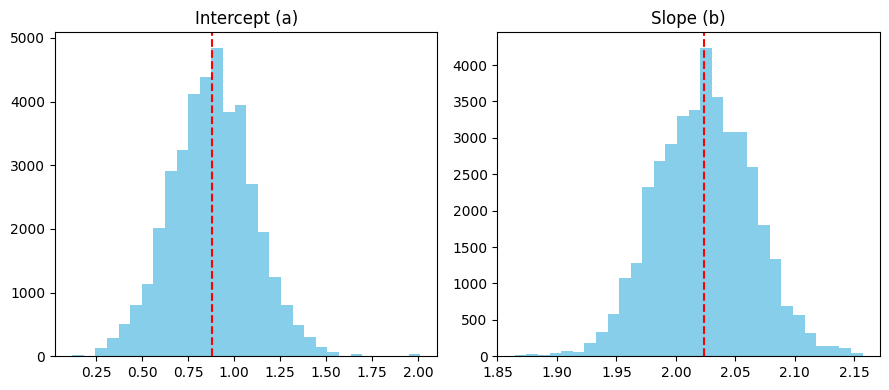

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

# --------------------------------------------------
# 0) generate the same 500 synthetic points
# --------------------------------------------------
np.random.seed(42)
sample_size = 500
sigma_e = 3.0                                   # known noise std
x = np.linspace(0, 10, sample_size)
y = 2.0 * x + 1.0 + np.random.normal(0, sigma_e, sample_size)

# --------------------------------------------------
# 1) prior: a, b ~ N(0.5, 0.5²)
# --------------------------------------------------
def log_prior(beta):
    a, b = beta                               # intercept, slope
    log_a = st.norm(0.5, 0.5).logpdf(a)
    log_b = st.norm(0.5, 0.5).logpdf(b)
    return log_a + log_b                      # log-probability

# --------------------------------------------------
# 2) likelihood under given beta
# --------------------------------------------------
def log_likelihood(beta):
    a, b = beta
    y_hat = a + b * x
    return np.sum(st.norm(y_hat, sigma_e).logpdf(y))

def log_posterior(beta):
    return log_likelihood(beta) + log_prior(beta)

# --------------------------------------------------
# 3) proposal: symmetric Gaussian around current beta
# --------------------------------------------------
def propose(beta):
    return beta + np.random.normal(0, 0.5, size=2)

# --------------------------------------------------
# 4) Metropolis-Hastings sampling
# --------------------------------------------------
n_steps = 50_000
results = np.zeros((n_steps, 2))
results[0] = np.array([0.5, 0.5])             # initial point

for t in range(1, n_steps):
    beta_old = results[t-1]
    beta_new = propose(beta_old)

    # log-space acceptance probability
    log_alpha = log_posterior(beta_new) - log_posterior(beta_old)
    alpha = np.exp(min(0, log_alpha))         # log→prob, cap at 1

    if np.random.rand() < alpha:              # accept
        results[t] = beta_new
    else:                                     # stay
        results[t] = beta_old

# --------------------------------------------------
# 5) discard burn-in & summarise posterior
# --------------------------------------------------
burn_in = 10_000
posterior_samples = results[burn_in:]
mean_a, mean_b = posterior_samples.mean(axis=0)
print(f"posterior mean  a = {mean_a:.3f},  b = {mean_b:.3f}")

# --------------------------------------------------
# 6) visualise marginal posterior histograms
# --------------------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
ax1.hist(posterior_samples[:, 0], bins=30, color="skyblue")
ax1.axvline(mean_a, color="red", ls="--");  ax1.set_title("Intercept (a)")

ax2.hist(posterior_samples[:, 1], bins=30, color="skyblue")
ax2.axvline(mean_b, color="red", ls="--");  ax2.set_title("Slope (b)")

plt.tight_layout();  plt.show()
